Our goal is to build a system for similar or reverse image search. Given a query image, it should quickly retrieve visually similar photos from a given image collection.

The steps we will take are as follows:

1. Preparing image collection and data

2. Building a baseline model

3. Index creation, retrieval and evaluation

4. Improving base system: Using other models

5. Improving base system: Sampling hard triplets

In [ ]:
# Check for GPU
!nvidia-smi -L 

In [2]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.8 MB/s eta 0:00:00


In [3]:
import glob
from itertools import chain
import os
import random
import zipfile
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from collections import defaultdict
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import faiss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models, utils
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

RANDOM_STATE = 64

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(RANDOM_STATE)

Mounted at /content/drive


## 1. Preparing image collection and data 

When deciding an initial image collection, it should fulfill a few conditions:
- The dataset should have sufficient samples per class. For Instance, the Oxford 102 Flower dataset only has a few samples per class for validation, which is insufficient for evaluating the model.
- The dataset should not be too big. For an initial system, we want to ensure that the whole pipeline works for a relatively small image collection first.

Thus, for this exercise, we will choose the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) as our image collection. It contains 60000 32x32 colour images in 10 classes, with 6000 images per class.

We can proceed to load and download the dataset from TorchVision.

In [4]:
trainset_cf = datasets.CIFAR10(root='./data', train=True, download=True)
testset_cf = datasets.CIFAR10(root='./data', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


The classes in our dataset are as follows. We can define a dictionary to be used later for mapping the target to the category.

In [5]:
trainset_cf.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [6]:
idx_to_class_mapping_cf = {v: k for k, v in trainset_cf.class_to_idx.items()}

The CIFAR-10 dataset doesn't have a validation set by default, therefore we will further split our training set to obtain it. It's common practice to create a validation set with a similar size to the test set. Therefore, we will follow this practice since our final training set still has sufficient samples for training.

We will end up with the following:
- Training set: 40K samples, which will be used to train the model
- Validation set: 10K samples, which will be used to validate and identify the best model
- Test set: 10K samples, which will be used for the final evaluation 

In [7]:
trainset_data_cf, valset_data_cf, trainset_targets_cf, valset_targets_cf = train_test_split(trainset_cf.data, trainset_cf.targets,
                                                    stratify=trainset_cf.targets, 
                                                    test_size=0.2, random_state = RANDOM_STATE)

In [ ]:
def count_classes(target_list):
    """Count number of samples per class in input list """
    class_count = {}
    for index in target_list:
        if index not in class_count:
            class_count[index] = 0
        class_count[index] += 1
    return collections.OrderedDict(sorted(class_count.items()))

print(count_classes(trainset_targets_cf))
print(count_classes(valset_targets_cf))

OrderedDict([(0, 4000), (1, 4000), (2, 4000), (3, 4000), (4, 4000), (5, 4000), (6, 4000), (7, 4000), (8, 4000), (9, 4000)])
OrderedDict([(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)])


In [8]:
def prep_target_dict(image_list, target_list):
    """Create dictionary with target label as key and list of images as value"""
    result_dict = {}
    for i in range(10):
        result_dict[i] = []
    
    for img, target in zip(image_list,target_list):
        result_dict[target].append(img)
    
    return result_dict

trainset_dict_cf = prep_target_dict(trainset_cf.data,trainset_cf.targets)
valset_dict_cf = prep_target_dict(valset_data_cf,valset_targets_cf)
testset_dict_cf = prep_target_dict(testset_cf.data,testset_cf.targets)

At this point, it's worthy to note how image similarity tasks are often tackled, given that this determines how the data is being prepared as well.

Commonly, siamese networks are used, with triplets as inputs:

- A triplet contains an "anchor" image, a "positive" image with the same class as the anchor, as well as a "negative" image with a different class as the anchor

- The model will learn representations such that the distance between the similar pair (anchor & positive) of inputs will be less than that of the dissimilar pair (anchor & negative) by some defined margin. This will be done by training the model to minimise Triplet Loss.

   > The base model employed here is commonly a neural network, since it can automatically learn features

As a result, we have to prepare our dataset in the form of triplets.

siamese.svg

In [39]:
class TripletData(Dataset):
    """Prepare triplets for training by random sampling"""
    def __init__(self, dictionary, transforms, cat_count):
        self.dictionary = dictionary
        self.cats = cat_count      # number of categories
        self.transforms = transforms
    
    def __getitem__(self, idx):
    
        # our positive class for the triplet
        idx = idx%self.cats

        # choosing our pair of positive images (im1, im2)
        im1, im2 = random.sample(self.dictionary[idx], 2)
        
        # choosing a negative class and negative image (im3)
        negative_cats = list(range(self.cats))
        negative_cats.remove(idx)
        negative_cat = random.choice(negative_cats)
        im3 = random.choice(self.dictionary[negative_cat])
        
        im1 = self.transforms(im1)
        im2 = self.transforms(im2)
        im3 = self.transforms(im3)
        
        return [im1, im2, im3]
        
    def __len__(self):
        return len(self.dictionary[0]) * self.cats    

image_transform_cf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Datasets and Dataloaders
train_data_cf = TripletData(trainset_dict_cf, image_transform_cf, cat_count=10)
val_data_cf = TripletData(valset_dict_cf, image_transform_cf, cat_count=10)
test_data_cf = TripletData(testset_dict_cf, image_transform_cf, cat_count=10)

train_loader_cf = DataLoader(dataset = train_data_cf, batch_size=32, shuffle=True, num_workers=0)
val_loader_cf = DataLoader(dataset = val_data_cf, batch_size=32, shuffle=False, num_workers=0)
test_loader_cf = DataLoader(dataset = test_data_cf, batch_size=32, shuffle=False, num_workers=0)

## 2. Building a baseline model

Now that we have prepared our data, we will proceed to define our TripletLoss function and our training loop.

In [40]:
class TripletLoss(nn.Module):
    """Compute Triplet Loss function with respect to anchor, positive and negative vectors"""
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    # Distances in embedding space is calculated in euclidean
    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [41]:
def train_model(model, model_name, train_loader, val_loader):
  """Train Siamese network, saving best model and training history"""
  epochs = 15
     
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = torch.jit.script(TripletLoss())
  history = defaultdict(list)                     #create dictionary to contain metrics
  best_loss = 100
  BEST_MODEL_PATH = './' + model_name + '.pth'

  # Training
  for epoch in range(epochs):
      print(f'Epoch {epoch + 1}/{epochs}')
      print('-' * 10)

      training_loss = []
      validation_loss = []
      model.train()
      for train_samples in tqdm(train_loader):
          x1,x2,x3 = train_samples                #anchor eg, positive eg, negative eg
          e1 = model(x1.to(device))
          e2 = model(x2.to(device))
          e3 = model(x3.to(device)) 
          
          optimizer.zero_grad()
          loss = criterion(e1,e2,e3)   #compute triplet loss given 3 examples
          loss.backward()
          optimizer.step()
          
          training_loss.append(loss.cpu().detach().numpy())
      avg_training_loss = np.mean(training_loss)
      print("Training Loss: {:.4f}".format(avg_training_loss))
      
      model.eval()
      with torch.no_grad():
        for val_samples in tqdm(val_loader):
            x1,x2,x3 = val_samples               
            e1 = model(x1.to(device))
            e2 = model(x2.to(device))
            e3 = model(x3.to(device)) 
            
            loss = criterion(e1,e2,e3)    
            validation_loss.append(loss.cpu().detach().numpy())
      avg_validation_loss = np.mean(validation_loss)
      print("Validation Loss: {:.4f}".format(avg_validation_loss))

      history['train_loss'].append(avg_training_loss)
      history['val_loss'].append(avg_validation_loss)

      if avg_validation_loss < best_loss:        
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = avg_validation_loss

  return model, history

For our baseline model, we will use a ResNet18 network. This is because ResNets tend to be good baselines, due to their characteristics such as residual connections that improve gradient flow and avoid exploding and vanishing gradients. 

In particular, we use ResNet18, a ResNet with 18 deep layers, as we want to use a simpler model as a baseline, and then use more complex models later to improve the baseline.

Epoch 1/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 4.0702


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.8832
Epoch 2/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.8630


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.7600
Epoch 3/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.7707


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.6922
Epoch 4/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.7905


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.7687
Epoch 5/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.7164


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.6425
Epoch 6/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.7252


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.6711
Epoch 7/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.6626


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.6302
Epoch 8/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.6764


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.6602
Epoch 9/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.6170


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.5653
Epoch 10/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.5641


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.6145
Epoch 11/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.5142


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.5397
Epoch 12/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.5161


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.5908
Epoch 13/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.4655


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.5453
Epoch 14/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.4129


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.4909
Epoch 15/15
----------


  0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.3827


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss: 0.4892


(0.0, 2.0)

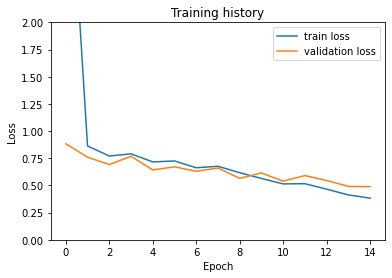

In [42]:
cf_model_1 = models.resnet18().to(device) 
cf_model_1, cf_history_1 = train_model(cf_model_1, 'cf_model_1', train_loader_cf, val_loader_cf)

plt.plot(cf_history_1['train_loss'], label='train loss')
plt.plot(cf_history_1['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2])

In [43]:
def evaluate_test_loss(model, test_loader):
  """Evaluate trained model on test set"""
  test_loss = []
  criterion = torch.jit.script(TripletLoss())

  model.eval()
  with torch.no_grad():
      for test_samples in tqdm(test_loader):
          x1,x2,x3 = test_samples               #anchor eg, positive eg, negative eg
          e1 = model(x1.to(device))
          e2 = model(x2.to(device))
          e3 = model(x3.to(device)) 
          
          loss = criterion(e1,e2,e3)    #compute triplet loss given 3 examples
          test_loss.append(loss.cpu().detach().numpy())
      avg_test_loss = np.mean(test_loss)
      print("Test Loss: {:.4f}".format(avg_test_loss))

evaluate_test_loss(cf_model_1, test_loader_cf)

  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.5034


## 3. Index creation, retrieval and evaluation

Now that we have a trained model, we can use the model to encode our images and store the representations in an index for retrieval.

To do so, we can use the Faiss Library, which is optimized for memory usage and speed for similarity search.

Faiss allows us to construct various indexes: Flat, LSH, HNSW and IVF. We shall construct an IVF index, given that it provides good search quality, with reasonable speed and memory usage.

In [44]:
def build_index(model, trainset_data, image_transform, d = 1000):
  """Build IVF index, given trained model and training set"""
  nlist = 100
  k = 4
  quantizer = faiss.IndexFlatL2(d)
  faiss_index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist)
  preds_list = []

  model.eval()
  with torch.no_grad():
      for image in trainset_data:
          image = image_transform(image).expand(size=(1,3,32,32))       #model accepts shape (batch size, image size)
          preds = model(image.to(device))                   
          preds = np.array([preds[0].cpu().numpy()])       
          preds_list.append(preds)

  preds_arr = np.vstack(preds_list)        #convert list of arrays to 2D array
  faiss.normalize_L2(preds_arr)
  faiss_index_ivf.train(preds_arr)
  faiss_index_ivf.add(preds_arr)           #add the representation to index
  return faiss_index_ivf

In [45]:
cf_faiss_index_1 = build_index(cf_model_1, trainset_data_cf, image_transform_cf)

After constructing our index, we can retrieve top k results from the index, given a query image.

In addition, we will also plot the images and display their corresponding classes to have a sense of how well the system is doing.

In [12]:
class ResultRetriever():
  """Class to retrieve search results from index and plot images"""
  def __init__(self, model, faiss_index_ivf, image_transform, testset_data, testset_targets, trainset_data, trainset_targets, idx_to_class_mapping):
    self.model = model
    self.faiss_index_ivf = faiss_index_ivf
    self.image_transform = image_transform
    self.testset_data = testset_data
    self.testset_targets = testset_targets
    self.trainset_data = trainset_data
    self.trainset_targets = trainset_targets 
    self.idx_to_class_mapping = idx_to_class_mapping

  def __retrieve_results(self, query_index, k=10):
    self.model.eval()
    with torch.no_grad():
      query_im = self.image_transform(self.testset_data[query_index]).expand(size=(1,3,32,32))
      query_im_embed = self.model(query_im.to(device)).cpu().detach().numpy()

      self.faiss_index_ivf.nprobe = 10      # set how many of nearest cells to search
      self.neighbor_distances, self.neighbor_indexes = self.faiss_index_ivf.search(query_im_embed, k)

  def __plot_query_image(self, query_index):
    target_index = self.testset_targets[query_index]
    target_class = self.idx_to_class_mapping[target_index]
    plt.imshow(self.testset_data[query_index])
    plt.title(target_class)
    plt.show()

  def __plot_result_images(self):
    fig = plt.figure(figsize=(20, 7))
    rows = 2
    columns = 5
    count = 1
    
    for dist, index in zip(self.neighbor_distances[0],self.neighbor_indexes[0]):
      target_index = self.trainset_targets[index]
      target_class = self.idx_to_class_mapping[target_index]

      ax = fig.add_subplot(rows, columns, count)
      ax.set_title(target_class + "\n(distance: " + str(dist) + ")", fontsize=12)
      plt.imshow(self.trainset_data[index])
      fig.tight_layout(pad=2.0)
      count += 1
    plt.show()

  def retrieve_and_plot_images(self, query_index, k=10):
    self.__retrieve_results(query_index, k)
    print("Queried image:")
    self.__plot_query_image(query_index)
    print("Retrieved images:")
    self.__plot_result_images()

  def evaluate_query_latency(self, k=10):
    start_time = time.time()
    self.__retrieve_results(0, k)
    end_time = time.time()
    query_latency = end_time - start_time
    print(f"\nQuery Latency: {query_latency:.3f}s")

In [46]:
cf_result_retriever_1 = ResultRetriever(cf_model_1, cf_faiss_index_1, image_transform_cf, testset_cf.data, testset_cf.targets, trainset_data_cf, trainset_targets_cf, idx_to_class_mapping_cf)

Queried image:


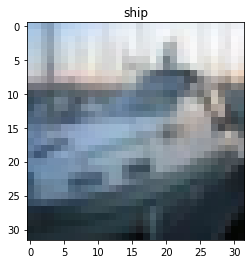

Retrieved images:


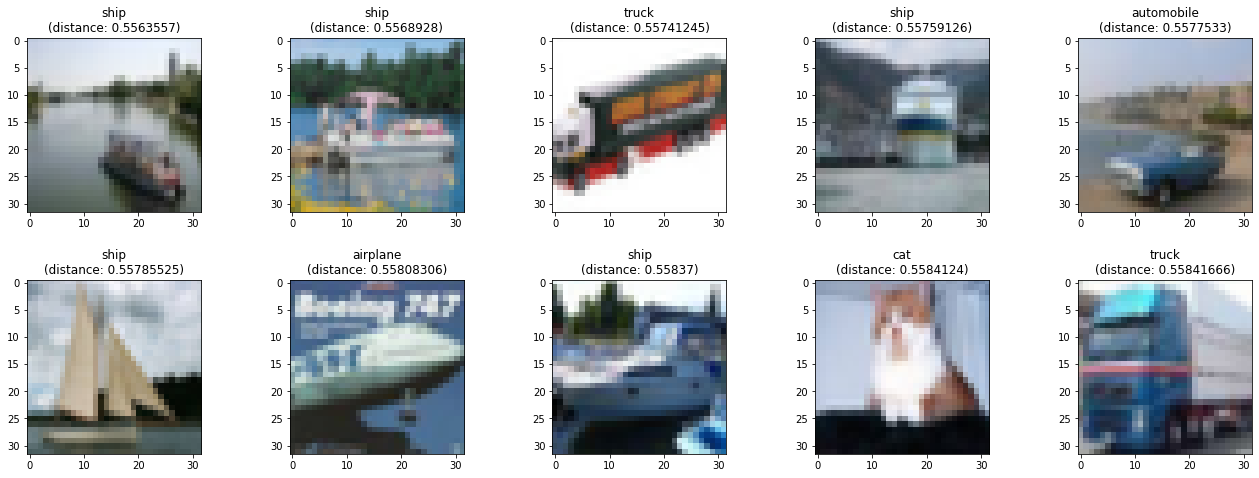

In [49]:
cf_result_retriever_1.retrieve_and_plot_images(2)

When trying the system with 1 query image (ship), we can see that among the top 10 results, 5 of them are relevant and have the same class. Furthermore, the relevant results seem to be ranked higher.

Apart from search relevance, we can also evaluate the latency to retrieve 10 results, given a query image:

In [50]:
cf_result_retriever_1.evaluate_query_latency()


Query Latency: 0.017s


So far, we have evaluated the system given 1 query image. 

A more formal way to evaluate image retrieval systems is to use an evaluation metric such as Mean Average Precision (MAP), which takes into account the ranking and relevance of the search results.

We will evaluate MAP@10 for 200 test query images, which is a common practice for evaluating image retrieval systems.

In [51]:
def precision_at_k(r, k):
    """Compute Precision @ k"""
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    """Compute Average Precision"""
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    """Compute Mean Average Precision"""
    return np.mean([average_precision(r) for r in rs])

In [52]:
#Get top 10 search results for 200 test samples, compute Mean Average Precision

def draw_rand_index(testset_data):
  """Draw a random index from test set"""
  return random.choice(range(len(testset_data)))

def evaluate_map_at_k(model, faiss_index_ivf, image_transform, testset_data, testset_targets, trainset_targets,  k=10):
  """Compute Mean Average Precision @ k"""
  rel_list_overall = []
  selected_indexes = []
  avg_precision_scores = []

  model.eval()
  with torch.no_grad():
    for i in range(200):
      query_index = draw_rand_index(testset_data)
      while query_index in selected_indexes:
        query_index = draw_rand_index(testset_data)
      else:
        selected_indexes.append(query_index)

        rel_list_per_image = []
        query_im = testset_data[query_index]
        query_im = image_transform(query_im).expand(size=(1,3,32,32))
        query_im_embed = model(query_im.to(device)).cpu().detach().numpy()

        faiss_index_ivf.nprobe = 10 
        _, neighbor_indexes = faiss_index_ivf.search(query_im_embed, k)

        #Compare each result image class with query class
        for neighbor_index in neighbor_indexes[0]:
          if trainset_targets[neighbor_index] == testset_targets[query_index]:
            rel_list_per_image.append(1)
          else:
            rel_list_per_image.append(0)
        rel_list_overall.append(rel_list_per_image)
        avg_precision_scores.append((query_index, average_precision(rel_list_per_image)))

  print("MAP@" + str(k) + ": " + str(mean_average_precision(rel_list_overall)))
  return mean_average_precision(rel_list_overall), avg_precision_scores

In [53]:
cf_map_1, cf_avg_precision_scores_1 = evaluate_map_at_k(cf_model_1, cf_faiss_index_1, image_transform_cf, testset_cf.data, testset_cf.targets, trainset_targets_cf)

MAP@10: 0.4855138424351222


Given that MAP is an average across all 200 query images, there are certain images which may have low Average Precision that the model performs badly on. We can do some error analysis by inspecting such samples.

In [54]:
#Identify queries with lowest Average Precision
cf_avg_precision_scores_1.sort(key = lambda x: x[1])
cf_avg_precision_scores_1[:5]

[(5385, 0.0), (7941, 0.0), (8354, 0.0), (9791, 0.0), (912, 0.0)]

Queried image:


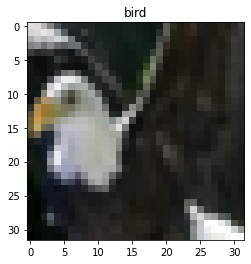

Retrieved images:


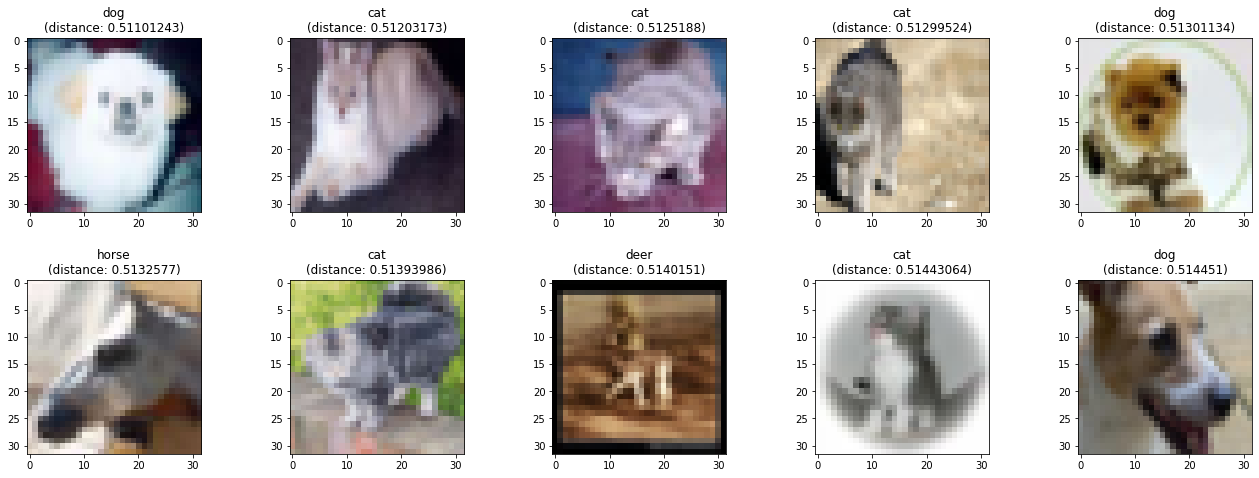

In [55]:
cf_result_retriever_1.retrieve_and_plot_images(5385)

We can see that for this particular query image, the system was unable to retrieve any relevant results. Instead, results from other classes such as dog, cat, horse and deer were retrieved.

## 4. Improving base system: Using other models

One way to improve the base system is to use other models, as they might be able to capture more patterns and learn better representations. In particular, we want to improve the system's MAP@10, while maintaining a similar query latency.

We will follow the same workflow above, but training and evaluating the following models instead:
- ResNet50
- EfficientNetB0
- EfficientNetB3
- MobileNetV2

In [ ]:
cf_model_2 = models.resnet50().to(device) 
cf_model_3 = models.efficientnet_b0().to(device)
cf_model_4 = models.efficientnet_b3().to(device)
cf_model_5 = models.mobilenet_v2().to(device)

cf_model_list = [cf_model_2, cf_model_3, cf_model_4, cf_model_5]
cf_result_retriever_list = []
cf_avg_precision_scores_list = []

for index, cf_model in enumerate(cf_model_list):

  cf_model, _ = train_model(cf_model, 'cf_model_' + str(index + 2), train_loader_cf, val_loader_cf)
  cf_faiss_index = build_index(cf_model, trainset_data_cf, image_transform_cf)
  cf_result_retriever = ResultRetriever(cf_model, cf_faiss_index, image_transform_cf, testset_cf.data, testset_cf.targets, trainset_data_cf, trainset_targets_cf, idx_to_class_mapping_cf)
  cf_result_retriever.evaluate_query_latency()
  cf_result_retriever_list.append(cf_result_retriever)

  cf_map, cf_avg_precision_scores = evaluate_map_at_k(cf_model, cf_faiss_index, image_transform_cf, testset_cf.data, testset_cf.targets, trainset_targets_cf)
  cf_avg_precision_scores_list.append(cf_avg_precision_scores)

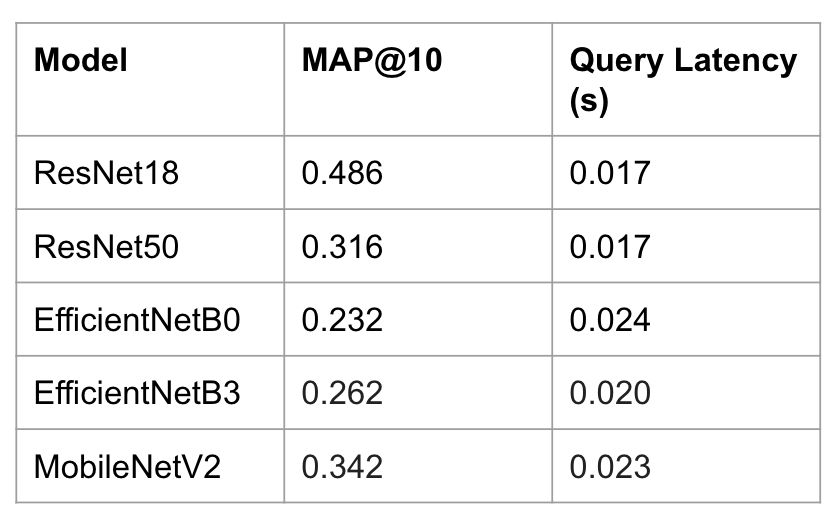

Out of all the models, it seems that our baseline model ResNet18 still performs the best in terms of search relevance and query latency.

I have a few hypotheses regarding this result:
- CIFAR-10 is a relatively simple dataset, therefore the increased complexity from ResNet50 may have caused poorer performance due to overfitting.
- Both EfficientNets performed poorly compared to the other models. This could be because CIFAR-10 dataset contains 32 x 32 images and EfficientNets tend to work better with larger image sizes.
- MobileNetV2 might have performed worse than ResNet18 due to the former having significantly less parameters and therefore failing to capture complex patterns.
- Lastly, the number of image representations stored in the index is not large (40K), which might explain why the query latency is similar across models.

## 5. Improving base system: Sampling hard triplets

Currently, we generate pairs/triplets randomly for training. However as the training continues, more and more triplets are easy to deal with (their loss value is very small or even 0), and our model will not learn much from them. To improve learning, we need to include more hard triplets, ie. triplets with high loss where the negative is closer to the anchor than the positive.

Given that hard triplets will have a large impact on our network parameters and may give mis-labelled data too much weight, we should adopt a strategy that mixes easy and hard triplets. In the [original paper](https://arxiv.org/abs/1503.03832), FaceNet chose to draw a relatively large random sample of triplets first, followed by choosing N/2 hard and N/2 random samples for a batch of size N.

Similarly, we will first draw a big batch of 400 random triplets, followed by drawing 32 hard triplets and 32 random triplets from the big batch. When drawing the random big batch, we will also make sure that the class distribution is adhered to.

In [174]:
#Training with hard triplets

def draw_random_batch(dictionary, image_transform, batch_size=400):
    """Draw random batch of triplets"""
    category_cnt = 10
    category_list = list(range(category_cnt))
    
    triplet_list = []
    for anchor_idx in category_list:                                 #pick 20 samples for each category
      for triplet_cnt in range(int(batch_size/category_cnt)):
          im1, im2 = random.sample(dictionary[anchor_idx], 2)

          # choosing a negative class and negative image (im3)
          neg_category_list = category_list.copy()
          neg_category_list.remove(anchor_idx)
          neg_idx = random.choice(neg_category_list)
          im3 = random.choice(dictionary[neg_idx])
          
          im1 = image_transform(im1)
          im2 = image_transform(im2)
          im3 = image_transform(im3)
          
          triplet_list.append([im1,im2,im3])
    return triplet_list

def draw_hard_triplets(dictionary, model, image_transform, draw_batch_size=400, hard_batch_size=32, rand_batch_size=32):
    """Generate batch containing hard triplets and random triplets from input batch"""
    initial_batch = draw_random_batch(dictionary, image_transform, draw_batch_size)
    data_loader = DataLoader(dataset = initial_batch, batch_size = draw_batch_size, shuffle=False, num_workers=0)
    model.eval()

    with torch.no_grad():
      for train_samples in data_loader:
          x1,x2,x3 = train_samples              
          A = model(x1.to(device)).cpu().detach().numpy() 
          P = model(x2.to(device)).cpu().detach().numpy() 
          N = model(x3.to(device)).cpu().detach().numpy() 
          #Compute d(A,P)-d(A,N)
          tripletloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Get hard samples with largest distance
    hard_samples_idx = np.argsort(tripletloss)[::-1][:hard_batch_size]
    hard_samples_dist = np.sort(tripletloss)[::-1][:hard_batch_size]
    hard_samples_count = sum([1 for dist in hard_samples_dist if dist > 0])
        
    #Draw other random samples from the batch
    rand_samples_idx = np.random.choice(np.delete(np.arange(draw_batch_size),hard_samples_idx),rand_batch_size,replace=False)

    #Combine hard samples with random samples
    final_samples_idx = np.append(hard_samples_idx,rand_samples_idx)

    #Retrieve corresponding images
    final_triplets = [initial_batch[batch_idx] for batch_idx in final_samples_idx]

    return final_triplets, hard_samples_count

We will train a new ResNet18 model from scratch, using the new sampling strategy. 

In [176]:
cf_model_hard_neg = models.resnet18().to(device) 

In [184]:
#training loop for hard triplets:
num_iterations = 10000
evaluate_every = 1000
draw_batch_size = 400
hard_batch_size = 32
BEST_MODEL_PATH_HARD_NEG = './cf_model_hard_neg.pth'

optimizer = optim.Adam(cf_model_hard_neg.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())
best_loss = 100
training_loss = []
validation_loss = []

for iteration in range(1,num_iterations+1):
    train_samples_hard_neg, hard_samples_count = draw_hard_triplets(trainset_dict_cf, cf_model_hard_neg, image_transform_cf, draw_batch_size, hard_batch_size)
    train_data_loader = DataLoader(dataset = train_samples_hard_neg, batch_size=64, shuffle=True, num_workers=0)
    
    cf_model_hard_neg.train()
    
    for train_samples in train_data_loader:
        x1,x2,x3 = train_samples                
        e1 = cf_model_hard_neg(x1.to(device))
        e2 = cf_model_hard_neg(x2.to(device))
        e3 = cf_model_hard_neg(x3.to(device)) 

        optimizer.zero_grad()
        loss = criterion(e1,e2,e3)         
        loss.backward()
        optimizer.step()
        training_loss.append(loss.cpu().detach().numpy())

    if iteration % evaluate_every == 0:
        avg_training_loss = np.mean(training_loss)
        cf_model_hard_neg.eval()
        with torch.no_grad():
          for val_samples in tqdm(val_loader_cf):
            x1,x2,x3 = val_samples               
            e1 = cf_model_hard_neg(x1.to(device))
            e2 = cf_model_hard_neg(x2.to(device))
            e3 = cf_model_hard_neg(x3.to(device)) 

            loss = criterion(e1,e2,e3)          
            validation_loss.append(loss.cpu().detach().numpy())

        avg_validation_loss = np.mean(validation_loss)
        print("Iteration {} - Training Loss: {:.4f}, Validation Loss: {:.4f}".format(iteration, avg_training_loss, avg_validation_loss))
        print("# Hard samples out of hard batch size: {}/{}".format(hard_samples_count, hard_batch_size))
        if avg_validation_loss < best_loss:
          torch.save(cf_model_hard_neg.state_dict(), BEST_MODEL_PATH_HARD_NEG)
          best_loss = avg_validation_loss

        training_loss = []     #empty list every 1000 iterations
        validation_loss = []

  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 1000 - Training Loss: 1.6426, Validation Loss: 0.9396
# Hard samples out of hard batch size: 32/32


  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 2000 - Training Loss: 1.4930, Validation Loss: 1.0146
# Hard samples out of hard batch size: 32/32


  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 3000 - Training Loss: 1.3525, Validation Loss: 1.1356
# Hard samples out of hard batch size: 32/32


  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 4000 - Training Loss: 1.2283, Validation Loss: 0.9981
# Hard samples out of hard batch size: 32/32


  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 5000 - Training Loss: 1.1410, Validation Loss: 1.0947
# Hard samples out of hard batch size: 32/32


  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 6000 - Training Loss: 1.0375, Validation Loss: 1.1205
# Hard samples out of hard batch size: 32/32


  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 7000 - Training Loss: 0.9682, Validation Loss: 1.0409
# Hard samples out of hard batch size: 32/32


  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 8000 - Training Loss: 0.9131, Validation Loss: 0.9924
# Hard samples out of hard batch size: 32/32


  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 9000 - Training Loss: 0.8724, Validation Loss: 0.9400
# Hard samples out of hard batch size: 32/32


  0%|          | 0/313 [00:00<?, ?it/s]

Iteration 10000 - Training Loss: 0.8454, Validation Loss: 1.0133
# Hard samples out of hard batch size: 32/32


After training the model for 10,000 iterations, we can build a new index and try retrieving images from the index.

In [191]:
cf_faiss_index_hard_neg = build_index(cf_model_hard_neg, trainset_data_cf, image_transform_cf)

In [192]:
cf_result_retriever_hard_neg = ResultRetriever(cf_model_hard_neg, cf_faiss_index_hard_neg, image_transform_cf, testset_cf.data, testset_cf.targets, trainset_data_cf, trainset_targets_cf, idx_to_class_mapping_cf)

Queried image:


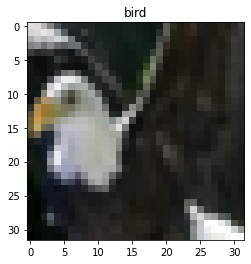

Retrieved images:


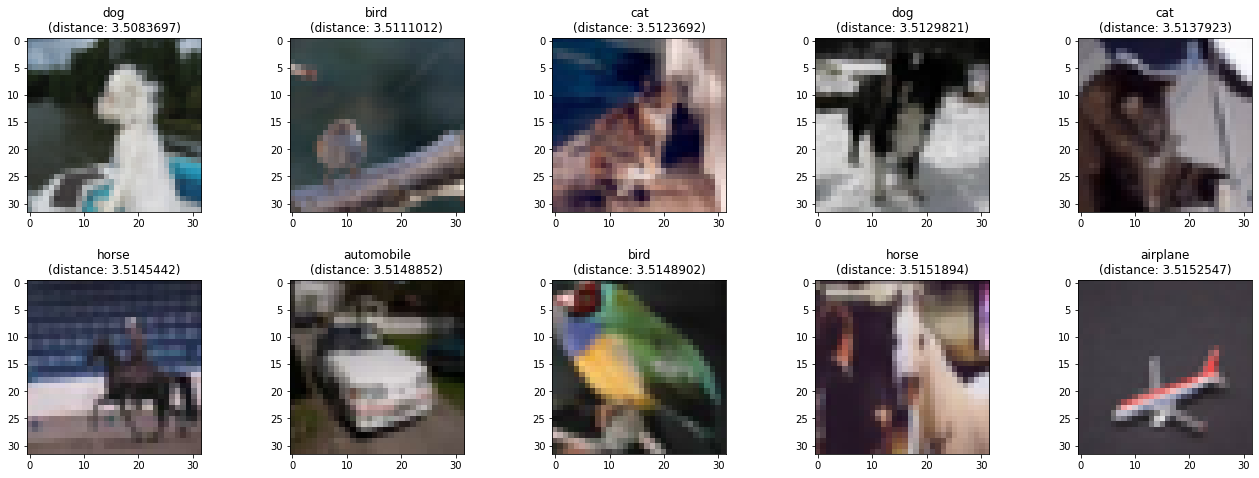

In [195]:
cf_result_retriever_hard_neg.retrieve_and_plot_images(5385)

Given the same query image (bird with index 5385) that our baseline model had failed to retrieve relevant results earlier, we see that the retrieved results are now better. Among the top 10 results, it now contains some results of the same class (bird).

This shows that using the new sampling strategy of incorporating hard negatives helped the model in achieving more relevant results for such cases.

Further training the model will likely improve search relevance even more, given that we have only trained for 10K iterations (64K triplets in total) compared to 15 epochs of 50K triplets each for our baseline model. 

## Conclusion

We have managed to develop an end-to-end image search system. Firstly, we built a base system using random triplet sampling, ResNet18 as the base model and IVF index for retrieval. We then tried to improve the base system performance by trying other models, as well as using a sampling strategy that incorporates hard negatives.

For future work, we can replicate the entire workflow for larger image collections. More complex models such as ResNet50 may work better if the dataset is more complex (eg. more classes). Given a larger dataset, query latency is also expected to increase. If the dataset size is not too huge (ie. millions of records), IVF index should still be a good option. Otherwise, we might have to consider LSH or HNSW indexes, which have faster query time. Last but not least, using a sampling strategy that incorporates hard negatives will still be important for training the models to deal with hard cases.
